In [49]:
import numpy as np 
import pandas as pd 

import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from glob import glob
import sys
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization

# 경로 설정

In [50]:
train_path = "../data/Paddy/train_images"
test_path = "../data/Paddy/test_images"

### 이미지 수 확인
* glob - .jpg 확장자를 가진 이미지 수

In [51]:
image_count = len(list(pathlib.Path(train_path).glob('*/*.jpg')))
print(image_count)

10407


### image_dataset_from_directory 함수, 각 수치는 Default
* tf.keras.utils.image_dataset_from_directory(
*     directory
    * 경로
*     labels='inferred'
    * inferred(디렉토리 구조에서 생성), None(레이블 없음) 
*     label_mode='int'
    * int : label이 정수로 인코딩, categorical : 범주형 벡터로 인코딩, binary : label이 2개만 존재 - float32값 0, 1로 인코딩 
*     class_names=None
    * labels = 'inferred'인 경우에만 적용, 클래스 순서를 제어하는데 사용
*     color_mode='rgb'
    * rgb or rgba 사용
*     batch_size=32
    * 데이터 배치의 크기, None인 경우 데이터가 일괄처리 되지 않음
*     image_size=(256, 256)
    * 이미지 크기 일괄적이여야 함
*     shuffle=True
    * 데이터를 섞을지 여부파악
*     seed=None
    * shuffle 변환을 위한 seed값
*     validation_split=None
    * 모델 자체평가 비율 0~1 부동소수점 값
*     subset=None,
    * 반환할 데이터의 하위 집합 training, validation, both
*     interpolation='bilinear'
    * 문자열 이미지 크기를 조정할 때 사용 - bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian을 지원
*     follow_links=False
    * 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
*     crop_to_aspect_ratio=False
    * True - 가로 세로 비율 왜곡 없이 이미지 크기를 조절
*     **kwargs
* )

In [52]:
training_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    # shuffle = False,
    seed=12,
    image_size=(448, 448),
    batch_size=16)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [53]:
val_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
#     shuffle = False,
    seed=12,
    image_size=(448, 448),
    batch_size=16)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [54]:
class_names = training_set.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


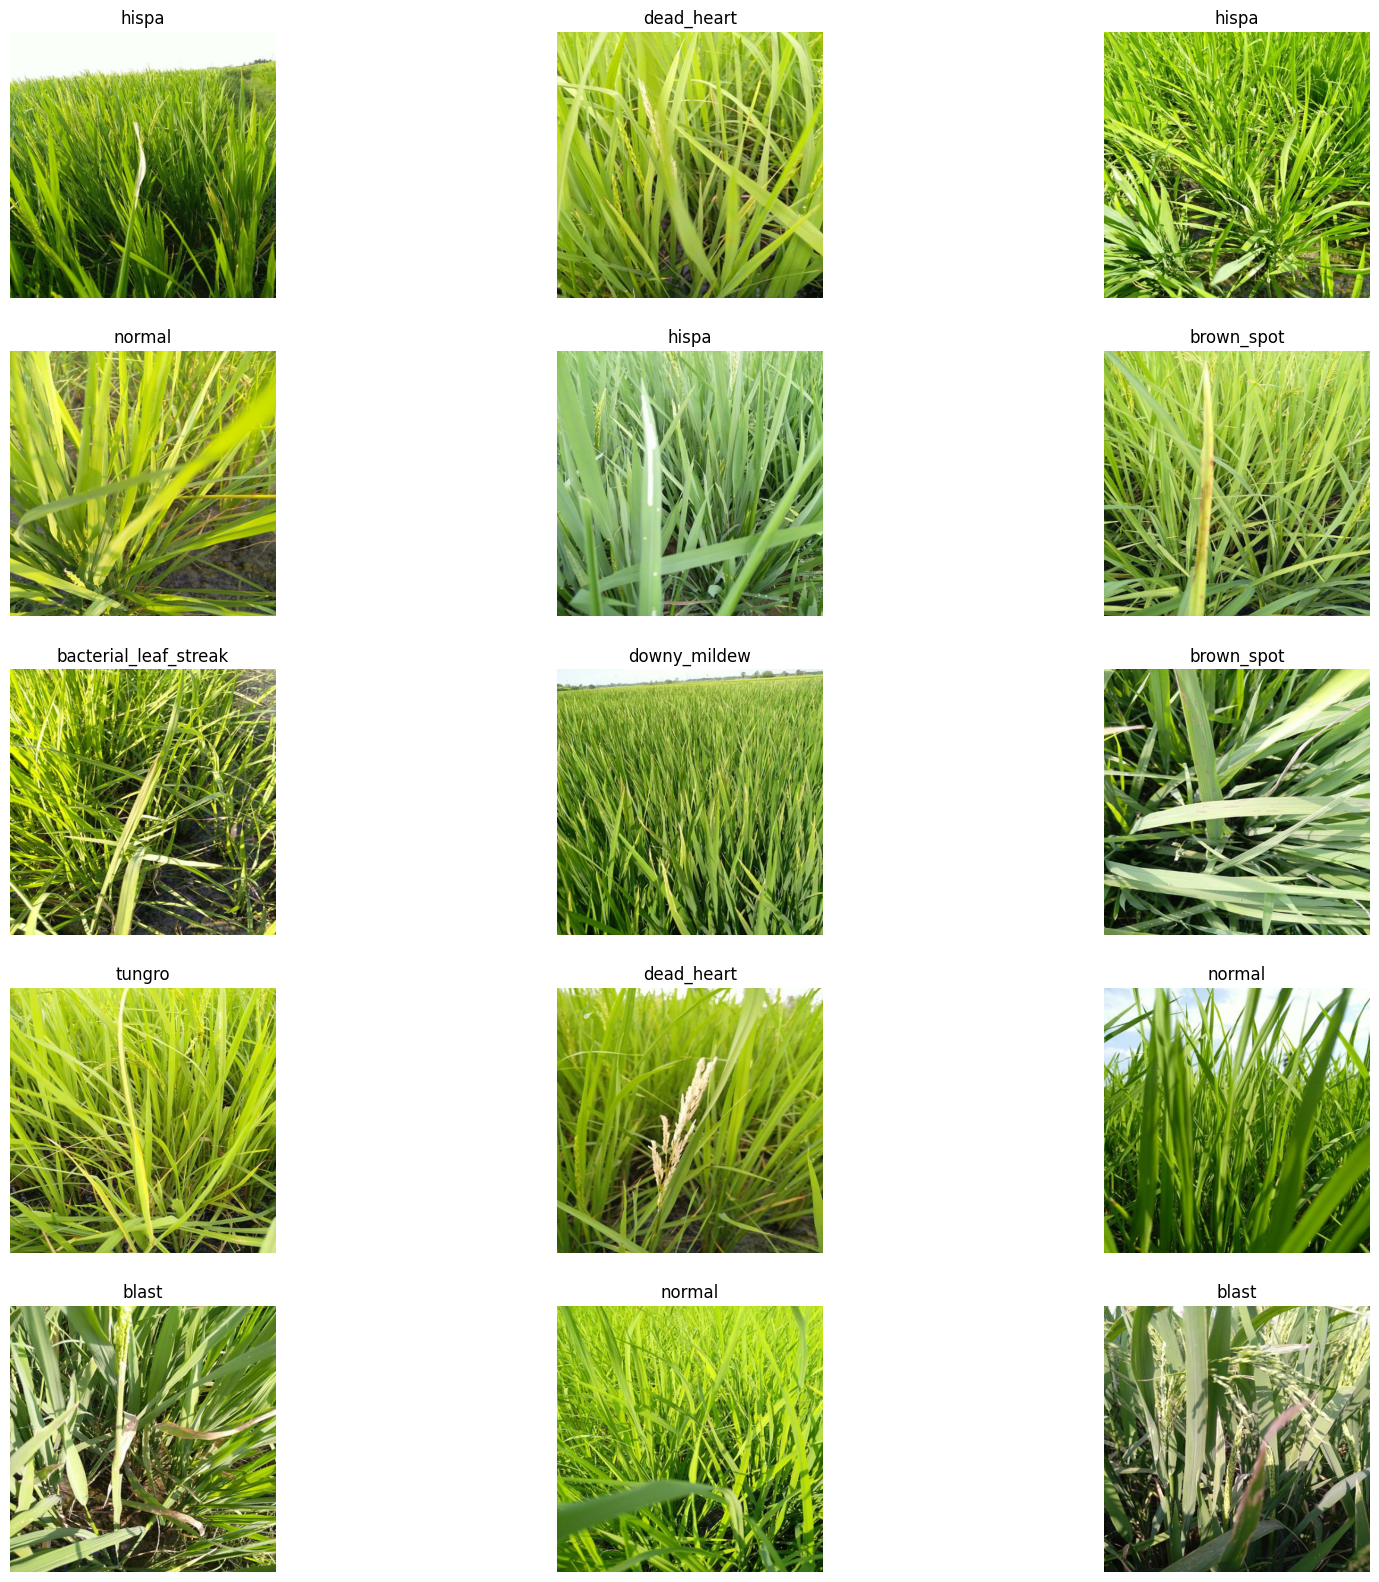

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in training_set.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [56]:
IMAGE_SIZE = [448, 448]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [57]:
for layer in inception.layers:
    layer.trainable = False

In [58]:
x = Flatten()(inception.output)

In [59]:
folders = glob(train_path+'/*')

In [60]:
prediction = Dense(len(folders), activation='softmax')(x)

In [61]:
model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [63]:
train_ds = train_datagen.flow_from_directory(train_path,
                                             target_size = (448, 448),
                                             batch_size = 16,
                                             class_mode = 'categorical',
                                             subset='training',
                                             shuffle = False)

Found 8330 images belonging to 10 classes.


In [64]:
val_ds = train_datagen.flow_from_directory(train_path,
                                             target_size = (448, 448),
                                             batch_size = 16,
                                             class_mode = 'categorical',
                                             subset='validation',
                                             shuffle = False)

Found 2077 images belonging to 10 classes.


In [65]:
%%time
tf.config.run_functions_eagerly(True)
r = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=50,
)

Epoch 1/50
  1/521 [..............................] - ETA: 8:42 - loss: 2.3769 - accuracy: 0.1875

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: Could not find callback with key=pyfunc_144 in the registry.
Traceback (most recent call last):

  File "c:\Users\JeongWoo\anaconda3\envs\tf22\lib\site-packages\tensorflow\python\ops\script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_144 in the registry.


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
probabilities = model.predict_generator(val_ds)
y_pred = np.argmax(probabilities, axis=1)

print(confusion_matrix(val_ds.classes, y_pred))

In [ ]:
cf_matrix = confusion_matrix(val_ds.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True)

In [ ]:
print(classification_report(val_ds.classes, y_pred))

In [ ]:
test_path = '../input/paddy-disease-classification/test_images'
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=test_path,
    target_size=(448, 448),
    batch_size=16,
    classes=['.'],
    shuffle=False,
)

In [ ]:
predict = model.predict(test_gen, verbose=1)

In [ ]:
predicted_class_indices=np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in train_ds.class_indices.items()}
predictions = [inv_map[k] for k in predicted_class_indices]

In [ ]:
filenames=test_gen.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submissioninseption3-4.csv",index=False)
results

In [ ]:
results['label'].value_counts()